In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('../../../')
from fastai.conv_learner import *
from fastai.dataset import *
from pathlib import Path
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler


# check to make sure you set the device
torch.cuda.set_device(0)

#use all the categories or narrow down to 3
use_categories = False
#whether to use all the data available (0 for all)
datasetSize = 0
#path to data
PATH = Path("../../data")
JPEGS = ""

# Data Preprocessing

## Data Loading
These are some helper functions to read the TXT files and convert it to a pandas dataframe for easier handling.<br>
The second one takes a list of parameters to be converted to numbers.

In [2]:
def read_txt_file(path):
    with open(path, "r") as f:
        data = []
        for i, line in enumerate(f):
            if i >= 2:
                data.append(line.split())
    return data

def get_dataframe(path, columns=None, convertList=[]):
    df = pd.DataFrame(read_txt_file(path),columns=columns)
    for i in convertList:
        df[i] = pd.to_numeric(df[i])
    return df

Load the the labels from the txt files and specify the name of each column

In [3]:
train_test_valid_anot = get_dataframe(PATH/'list_eval_partition.txt',
                                     columns=["Path", "use"])

fileName2bbox = get_dataframe(PATH/'list_bbox.txt',
                             columns=['Path', 'x1', 'y1', 'x2', 'y2'],
                             convertList=["x1","x2","y1","y2"])

fileName2cat = get_dataframe(PATH/'list_category_img.txt',
                            columns=['Path', 'cat'],
                            convertList=["cat"])

cat2type = get_dataframe(PATH/'list_category_cloth.txt',
                        columns=["cat","type"],
                        convertList=["type"])

If the use_categories parameter is set, we are using all the 49 categories, if not we are only using <i><b>Top, Bottoms, Full Body</b></i>

In [4]:
if use_categories:
    cats = dict((i+1, cat[0]) for i, cat in enumerate(read_txt_file(PATH/'list_category_cloth.txt')))
else:
    cats = {1: "Top", 2: "Bottoms", 3: "Full Body"}
    cat2type["cat_index"] = np.arange(len(cat2type)) + 1
    cat2type_dict = dict((cat, tp) for cat, tp in zip(cat2type["cat_index"], cat2type["type"]))
    for (cat, tp) in cat2type_dict.items():
        fileName2cat["cat"] = fileName2cat["cat"].replace(cat, tp)

Merge all the dataframes into and add an index to it

In [5]:
final_ann = fileName2bbox.merge(train_test_valid_anot).merge(fileName2cat)
final_ann = final_ann.reset_index()
final_ann.head()

,index,Path,x1,y1,x2,y2,use,cat
0,0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273,train,1
1,1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161,train,1
2,2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,val,1
3,3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182,train,1
4,4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262,test,1


Cut the size of the dataset if needed for testing and faster training

In [6]:
if datasetSize:
    final_ann = final_ann[0:datasetSize]

Convert the dataframe to a Python dictionary with id -> (bbox, cat) relationships

In [7]:
image_ann = dict((ID, [(np.array([y1,x1,y2,x2]), cat_id)])
                 for ID, cat_id, x1, y1, x2, y2 in zip(final_ann["index"],
                                                       final_ann["cat"],
                                                       final_ann["x1"],
                                                       final_ann["y1"],
                                                       final_ann["x2"],
                                                       final_ann["y2"] ))

trn_fns = dict((ID,filename) for ID, filename in zip(final_ann["index"], final_ann["Path"]))
trn_ids = [ID for ID in final_ann["index"]]

Map the category_id to category_name and vice versa

In [8]:
#fix the index to start from 0
id2cat = list(cats.values())

#a dictionary in the opposite direction
cat2id = {c:i for i,c in enumerate(id2cat)}
cat2id

{'Top': 0, 'Bottoms': 1, 'Full Body': 2}

The fastai lib expects those parameters to be passed when creating the model data object

In [9]:
#the backbone architecture
f_model=resnet34
#the size to which the input will be resized
size=224
#the number of items in a batch
batch_size=128

Preparing separate structures with the categories and the ids is needed since the fastai library does not provide the functionality to include both.

In [10]:
mcs = np.array([np.array([cat2id[cats[image_ann[o][0][1]]]]) for o in trn_ids])
len(mcs)

289222

Splitting the data into validation and training datasets is needed because the fastai library expects both. After training the validation dataset is used to report the error on unseen samples (validation labels are only used to calculate the error, not for training)<br> The chosen ration is <b>20%</b> validation data set

In [11]:
#get random validation indexes for cross-validation and split the data
val_idxs = final_ann[final_ann["use"] == "test"]["index"]
((val_cats,trn_cats),) = split_by_idx(val_idxs, mcs)
len(trn_cats), len(val_cats)

(249222, 40000)

Prepare the bbox information as a CSV file to be passed to the ModelData object

In [12]:
#save the bbox information in a CSV file to pass to the library
model_bbs = [np.concatenate([p[0] for p in image_ann[o]]) for o in trn_ids]
model_bbsc = [' '.join(str(p) for p in o) for o in model_bbs]

MBB_CSV = PATH/'tmp/mbb.csv'
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': model_bbsc}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)
df.head()

,fn,bbox
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,79 72 273 232
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,59 67 161 155
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65 65 200 156
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,62 51 182 167
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,88 46 262 166


# Model

The fastai library does the data augmentation behind the scenes. Since we are dealing with the coordinates of the bounding boxes, the transform type (COORD) needs to be passed to the list with augmentations to be applied to the data. This way it will move the bounding boxes accordingly.

In [13]:
aug_tfms = [RandomRotate(10, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]

tfms = tfms_from_model(f_model,
                       size,
                       crop_type=CropType.NO,
                       tfm_y=TfmType.COORD,
                       aug_tfms=aug_tfms)

The fastai model data object contains all the information about the data - the path to the data, the annotations, the transforms, the validation indexes, the batch sizes it is going to be split into

In [14]:
md = ImageClassifierData.from_csv(PATH,
                                  JPEGS,
                                  MBB_CSV,
                                  tfms=tfms,
                                  continuous=True,
                                  num_workers=4,
                                  val_idxs=val_idxs,
                                  bs=batch_size)

##### The library does not provide the functionality to have multiple labels from different categories (In this case, two separate labelings are necessary - the bboxes on the image and category of each item). That is a custom class that concatenates two datasets: image-category and image-bbox. It inherits from the Pytorch Dataset object

In [15]:
class ConcatedDataset(Dataset):
    def __init__(self, ds1, ds2):
        self.ds = ds1
        self.ds2 = ds2
        self.sz = ds1.sz
        
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.ds2[i]))

In [16]:
trn_ds2 = ConcatedDataset(md.trn_ds, trn_cats)
val_ds2 = ConcatedDataset(md.val_ds, val_cats)

md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

## Data Visualisation

Since some libraries like matplotlib take another format of the bounding boxes, that is a helper function to convert them <br> <b>(x1, y1, x2, y2) -> (x1, x2, height, width)

In [17]:
def bb_hw(bbox): return np.array([bbox[1], bbox[0], bbox[3]-bbox[1], bbox[2]-bbox[0]])

Some basic plotting functions to display an image, a box and text, these are combined to achieve more complex plotting functions

In [18]:
def show_img(im, ax=None, figsize=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    return ax

def show_box(ax, bbox):
    patch = ax.add_patch(patches.Rectangle(bbox[:2], *bbox[-2:], fill=False, edgecolor='white', lw=2))
    set_outline(patch, 4)

def show_text(ax, pos, text):
    text = ax.text(*pos, text, verticalalignment='top',color='white', weight='bold')
    set_outline(text, 1)
    
def set_outline(obj, linewidth):
    obj.set_path_effects([patheffects.Stroke(linewidth=linewidth, foreground='black'), patheffects.Normal()])

Display an image with the bounding box and the class labeled for each item, could also be used to display results together with their probabilities which can be passed as the prs parameter. Only the probabilities above the threshold will be shown.

In [19]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.4):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            show_text(ax, b[:2], txt)
            show_box(ax, b)

Same as the one above but for PyTorch tensors, it converts them to numpy and passes them along to the function above

In [20]:
def torch_display_gt(ax, ima, bbox, clas=None, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*size).long()),
         to_np(clas) if clas is not None else None, to_np(prs) if prs is not None else None, thresh)

Display a batch of the data to make sure it all looks alright

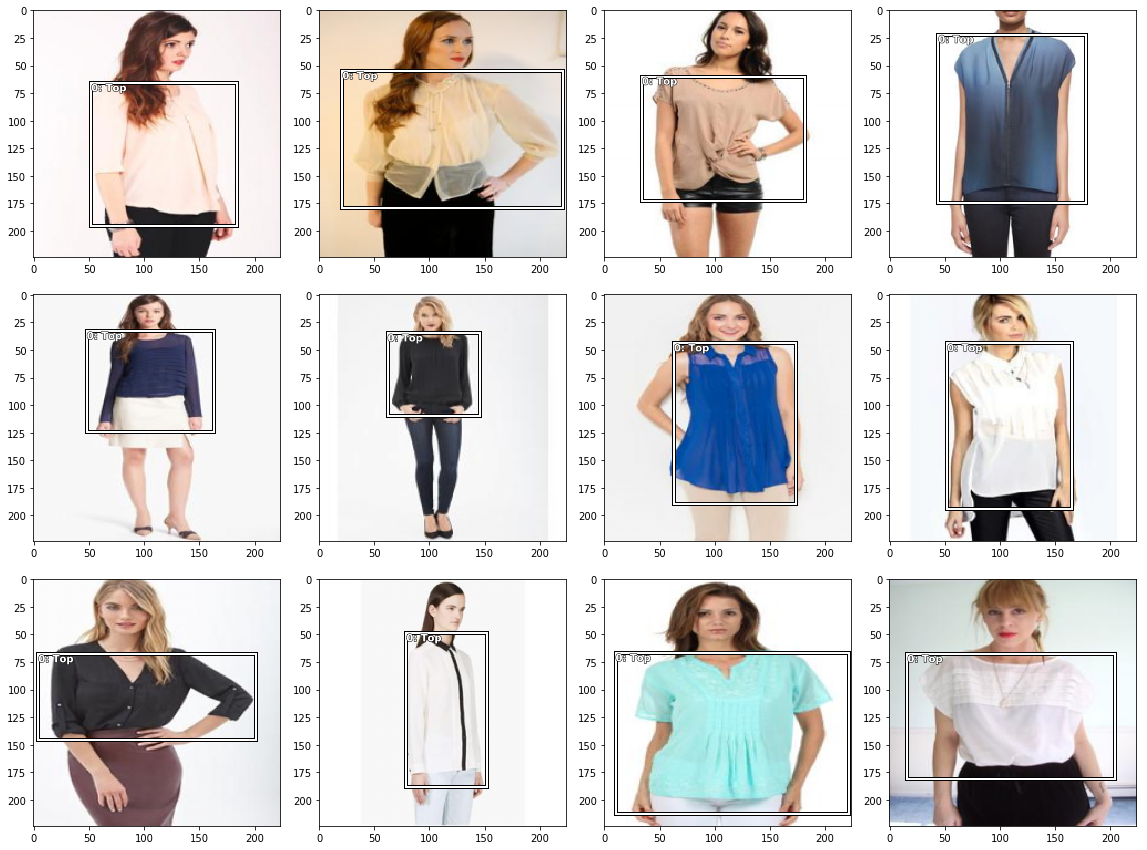

In [21]:
#get a batch from the modeldata object and normalize it
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

#display the results using matplotlib
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

## Data Statistics

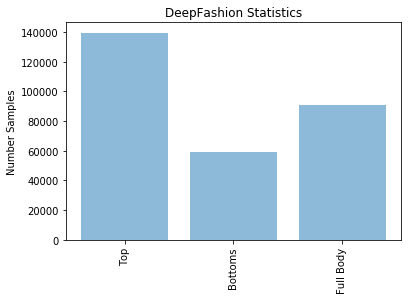

In [22]:
#the unique categories
cs = pd.unique(final_ann["cat"])

#dict - category_name -> the number of occurances
ls_dict = dict((cats[c],len(final_ann[final_ann["cat"]==c])) for c in cs)

#the name of the categories
categories = ls_dict.keys()
y_pos = np.arange(len(categories))

#matplotlib display
plt.bar(y_pos, ls_dict.values(), align='center', alpha=0.5)
plt.xticks(y_pos, categories,  rotation='vertical')
plt.ylabel('Number Samples')
plt.title('DeepFashion Statistics')
plt.show()

# Model
## Default Anchor boxes

Convert from <b>(centre_x, centre_y, height, width) -> (x1, y1, x2, y2)</b>

In [23]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

Create the default anchor boxes (to change their number and size just change the first 3 variables)

In [24]:
anchor_grid_sizes = [28,14,7,4,2,1]
anchor_zooms =  [.7, 2**0, 2**(1/3), 2**(2/3)]
anchor_ratios = [(1.,1.), (.5,1.), (1.,.5), (3.,1.), (1.,3.)]

anchor_scales = [(zoom*n, zoom*m) for zoom in anchor_zooms for (n, m) in anchor_ratios]
k = len(anchor_scales)

# the center offsets
anchor_offsets = [1/(size*2) for size in anchor_grid_sizes]

# create the x coordinates for the anchors
anchor_xs = np.concatenate([np.repeat(np.linspace(offset, 1-offset, gsize), gsize)
                            for offset, gsize in zip(anchor_offsets, anchor_grid_sizes)])

# create the y coordinates for the anchors
anchor_ys = np.concatenate([np.tile(np.linspace(offset, 1-offset, gsize), gsize)
                            for offset, gsize in zip(anchor_offsets, anchor_grid_sizes)])

# create k anchor boxes per grid cell, all with the  same center coordinates
anchor_centres = np.repeat(np.stack([anchor_xs, anchor_ys], axis=1), k, axis=0)

# create the height and width of the anchors
anchor_sizes = np.concatenate([np.array([[h/gsize, w/gsize] for i in range(gsize*gsize) for h,w in anchor_scales])
                            for gsize in anchor_grid_sizes])

# create a pytorch variable with the size of the grid cell for each default anchor box
grid_sizes = V(np.concatenate([np.array([1/gsize for i in range(gsize*gsize) for h,w in anchor_scales])
               for gsize in anchor_grid_sizes]), requires_grad=False).unsqueeze(1)

# create the anchor coordinates (x_center, y_center, height, width)
anchor_hws = V(np.concatenate([anchor_centres, anchor_sizes], axis=1), requires_grad=False).float()

# convert the format to (x1,x2,y1,y2)
anchor_corners = hw2corners(anchor_hws[:,:2], anchor_hws[:,2:])

Visualize a the anchor boxes in a single cell

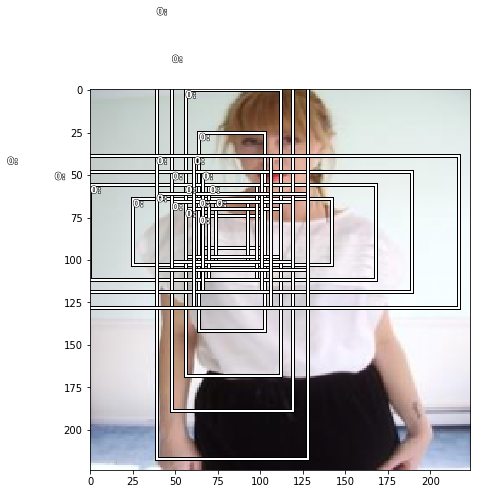

In [25]:
x,y=to_np(next(iter(md.val_dl)))
idx=11
ima=md.val_ds.ds.denorm(to_np(x))[idx]
fig, ax = plt.subplots(figsize=(7,7))
for j in range(k):
    torch_display_gt(ax, ima, anchor_corners[1034*k+j])

## Loss Function

A utility function which converts integers to one hot embeddings for  the passed labels

In [26]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

### Categorical Loss 
The categorical Focal Loss as defined in the RetinaNet paper

In [27]:
class FocalLoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, preds, targets):
        # create a one hot embedding for the targets
        t = one_hot_embedding(targets, self.num_classes+1)
        # discard the background column in both predictions and targets
        t = V(t[:,:-1].contiguous()) 
        x = preds[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes
    
    def get_weight(self, x, t):
        alpha,gamma = 0.25,1.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

focal_loss = FocalLoss(len(id2cat))

### Bounding Boxes loss
Utility functions to find the jaccard index <br> <img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png"></img>
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Intersection_over_Union_-_poor%2C_good_and_excellent_score.png"></img>

In [28]:
# get the intersection of the boxes
def intersection(first_box, second_box):
    min_xy = torch.max(first_box[:,None,:2], second_box[None,:,:2])
    max_xy = torch.min(first_box[:,None,2:], second_box[None,:,2:])
    inter = torch.clamp(max_xy - min_xy,min=0)
    return inter[:,:,0] * inter[:,:,1]

# get the size of the bounding box
def get_size(bbox):
    return (bbox[:,2] - bbox[:,0]) * (bbox[:,3] - bbox[:,1])

# get the jaccard index
def jaccard(first_box, second_box):
    inter = intersection(first_box, second_box)
    union = get_size(first_box).unsqueeze(1) + get_size(second_box).unsqueeze(0) - inter
    return inter/union

Get the responsible anchor boxes for each target object based on the jaccard index

In [29]:
def map_targets_to_anchors(overlaps):
    # for each object - get the grid cell it overlaps most with
    prior_overlap, prior_idx = overlaps.max(1)
    
    # for each anchor box - get the object it overlaps most wih
    gt_overlap, gt_idx = overlaps.max(0)
    
    # set high overlap for all the anchor boxes which have been assigned by the maximum object overlap
    gt_overlap[prior_idx] = 1.99
    
    # set the index of the overlapping object
    for i,o in enumerate(prior_idx): gt_idx[o] = i
        
    # return the final overlaps and indexes
    return gt_overlap, gt_idx

Remove the zero padding which is added by the fastai library in the target bbox/class

In [30]:
def unpad(bboxes, clas):
    #reshape the array in sets of 4 (4 coordinates for a bounding bbox)
    bboxes = bboxes.view(-1,4)/size
    #get the non zero indexes, ie remove the 0 padding
    bboxes_keep = ((bboxes[:,2] - bboxes[:,0])>0.).nonzero().squeeze()
    #only keep the indexes of these items
    return bboxes[bboxes_keep], clas[bboxes_keep]

Convert the activations to bounding boxes

In [31]:
def preds_to_bbs(actn, anchor_hws):
    # run the activations through a non-linear layer
    preds_bbs = torch.tanh(actn)
    # convert the first two activations to offsets in the centers of the default anchor boxes
    preds_ctrs = torch.clamp(((preds_bbs[:,:2] * grid_sizes) + anchor_hws[:,:2]), 0, size)
    # convert the the second two activations to scaled height and width of default anchor boxes
    preds_hw = torch.clamp(((1 + preds_bbs[:,2:]) * anchor_hws[:,2:]), 0, size)
    # convert the bounding boxes from (center_x, center_y, height, widht) -> (x1,x2,y1,y2)
    return hw2corners(preds_ctrs, preds_hw)

Define the final loss function a combination of categorical loss and bounding boxes loss. For each item from the batch calculate the single loss and add it to the total

In [32]:
def ssd_1_loss(pred_cat, pred_bb, targ_bb, targ_cat):
    # remove the 0 padding
    targ_bb, targ_cat = unpad(targ_bb, targ_cat)
    
    # covert the model output to bounding box coordinates
    pred_bb = preds_to_bbs(pred_bb, anchor_hws)
        
    # calculate the overlapping between the ground truth objects and the anchor boxes
    overlaps = jaccard(targ_bb.data, anchor_corners.data)
    
    # the get the size of overlapping and the index of the overlapping objects for each anchor box
    # the first is the highest overlap for each grid cell
    # the second is the index of the ground truth object that overlaps most
    gt_overlap, gt_idx = map_targets_to_anchors(overlaps)
    
    # keep only the ones with more than 0.4 overlap and get their indexes
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos).squeeze()   
    
    # convert the indexes to bounding boxes
    gt_bboxes = targ_bb[gt_idx]
    
    # calculate the mean error in the predicted coordinates and the real ones
    loss_bboxes = ((pred_bb[pos_idx] - gt_bboxes[pos_idx]).abs()).mean()
    
    # convert the indexes to class ids
    gt_cat = targ_cat[gt_idx]
    
    # set the class for the ones with less than 0.4 overlap to "background"
    gt_cat[1-pos] = len(id2cat)
    
    # calculate the average loss for the categories
    loss_cat  = focal_loss(pred_cat, gt_cat) / len(pos_idx)
    
    return loss_bboxes, loss_cat

def ssd_loss(pred,targ,print_it=False):
    final_loss_cat, final_loss_bboxes = 0.,0.
    # calculate the error for each of the samples from the batch
    for pred_cat, pred_bb, targ_bb, targ_cat in zip(*pred,*targ):
        
        # skip images with no items ont them
        if  len(((targ_bb.view(-1,4)[:,2]-targ_bb.view(-1,4)[:,0])>0).nonzero())==0:
            continue
            
        # calculate the loss for the specific sample
        loss_bboxes, loss_cat = ssd_1_loss(pred_cat, pred_bb, targ_bb, targ_cat)
        
        #add to the final loss
        final_loss_bboxes += loss_bboxes
        final_loss_cat += loss_cat
    
    # return the combined loss
    return final_loss_bboxes + final_loss_cat

## Model Architecture

Define a standard Convolutional Layer which is followed by <br>
<b>BatchNorm, ReLU and Dropout layer</b>, which is what is the most widely-used combination in practice

In [33]:
def conv_layer(num_in, num_out, stride=2, dp= 0.1):
    return nn.Sequential(
        nn.Conv2d(num_in, num_out, 3, bias=False, stride=stride, padding=1),
        nn.BatchNorm2d(num_out, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True),
        nn.Dropout(dp))

A template output layer with the number of filter:<br>
1. for the categories -> <b>(number of the categories + 1 for background) *  the number of anchor boxes per grid cell</b> <br>
2. for the bounding boxes -> <b>4 *  the number of anchor boxes per grid cell </b>

In [34]:
class OutputConvolution(nn.Module):
    def __init__(self, k, num_in, bias):
        super().__init__()
        
        self.cat_output = nn.Conv2d(num_in, (len(id2cat)+1) * k, 3, padding=1)
        self.cat_output.bias.data.zero_().add_(bias)

        self.bbox_output = nn.Conv2d(num_in, 4 * k, 3, padding = 1)
        self.k = k
        
    def forward(self, x):
        return [flatten(self.cat_output(x), self.k),
                flatten(self.bbox_output(x), self.k)]
    
def flatten(x, k):
    batch_size, num_filters, _, _ = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(batch_size, -1, num_filters//k)

A Class that registers a forward hook to the specific PyTorch module and saves the output activations in a local variable, it is needed to get the activations from the backbone (ResNet) layers to construct the FPN

In [35]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
        self.features_in = input
    def remove(self): self.hook.remove()

The final FPN architecture which uses 28x28, 14x14, 7x7, 4x4, 2x2, 1x1 layers

In [36]:
drop = 0.4

class FPN_SSD_Model(nn.Module):
    def __init__(self, model_base, k, bias):
        super().__init__()

        self.model_base = model_base
        self.drop = nn.Dropout(drop)

        # The convolutional layers that reduce the grid size
        # that form the top-down pathway (28x28, 14x14, 7x7, 4x4, 2x2, 1x1)
        self.saved_features = [SaveFeatures(model_base[i]) for i in [5,6]]
        self.conv7 = conv_layer(512,256, dp=drop, stride=1) 
        self.conv4 = conv_layer(256,256, dp=drop) 
        self.conv2 = conv_layer(256,256, dp=drop) 
        self.conv1 = conv_layer(256,256, dp=drop) 
        
        # Layers for forming the lateral connections (28x28, 14x14, 7x7, 4x4, 2x2, 1x1)
        self.lat28 = nn.Conv2d(128,256,kernel_size=1, stride=1, padding=0)
        self.lat14 = nn.Conv2d(256,256,kernel_size=1, stride=1, padding=0)
        self.lat7 = nn.Conv2d(256,256,kernel_size=1, stride=1, padding=0)
        self.lat4 = nn.Conv2d(256,256,kernel_size=1, stride=1, padding=0)
        self.lat2 = nn.Conv2d(256,256,kernel_size=1, stride=1, padding=0)
        self.lat1 = nn.Conv2d(256,256,kernel_size=1, stride=1, padding=0)
        
        # The upsampling layers that increase the grid size
        # that from the bottom-up pathway (2x2, 4x4, 7x7, 14x14, 28x28)
        self.upsamp2 = nn.Upsample(size=(2,2), mode='bilinear')
        self.upsamp4 = nn.Upsample(size=(4,4), mode='bilinear')
        self.upsamp7 = nn.Upsample(size=(7,7), mode='bilinear')
        self.upsamp14 = nn.Upsample(size=(14,14), mode='bilinear')
        self.upsamp28 = nn.Upsample(size=(28,28), mode='bilinear')
        
        # The output convolutional layer to split the network
        # for categories and bounding boxes (28x28, 14x14, 7x7, 4x4, 2x2, 1x1)
        self.out28 = OutputConvolution(k, 256, bias)
        self.out14 = OutputConvolution(k, 256, bias)
        self.out7 = OutputConvolution(k, 256, bias)
        self.out4 = OutputConvolution(k, 256, bias)
        self.out2 = OutputConvolution(k, 256, bias)
        self.out1 = OutputConvolution(k, 256, bias)

    def forward(self,x):
        # get the activations from the pre-trained model
        x = self.drop(F.relu(self.model_base(x)))
        
        # get the activations from reducing the grid size
        c28 = F.relu(self.saved_features[0].features)
        c14 = F.relu(self.saved_features[1].features)
        c7 = self.conv7(x)
        c4 = self.conv4(c7)
        c2 = self.conv2(c4)
        c1 = self.conv1(c2)
       
        # Upsampling and joining the lateral connections
        p1 = self.lat1(c1)
        p2 = self.upsamp2(p1) + self.lat2(c2)    
        p4 = self.upsamp4(p2) + self.lat4(c4)
        p7 = self.upsamp7(p4) + self.lat7(c7)
        p14 = self.upsamp14(p7) + self.lat14(c14)
        p28 = self.upsamp28(p14) + self.lat28(c28)
        
        # making the final predictions
        out28cat,out28bbox = self.out28(p28)
        out14cat,out14bbox = self.out14(p14)
        out7cat,out7bbox = self.out7(p7)
        out4cat,out4bbox = self.out4(p4)
        out2cat,out2bbox = self.out2(p2)
        out1cat,out1bbox = self.out1(p1)
        
        # concatenate all the predictions together
        return [torch.cat([out28cat, out14cat, out7cat, out4cat, out2cat, out1cat], dim=1),
                torch.cat([out28bbox, out14bbox, out7bbox, out4bbox, out2bbox, out1bbox], dim=1)]

Cut the model as defined by the model meta data to get the backbone to be used by the FNP

In [37]:
def get_base(f_model):
    cut, _ = model_meta[f_model]
    layers = cut_model(f_model(True), cut)
    return nn.Sequential(*layers)

Make the model compatible with the fast ai library ConvLearner, needs to specify the layer groupds which are used internally

In [38]:
cut,lr_cut = model_meta[f_model]

class MakeModel():
    def __init__(self,model,name='makemodel'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.model_base), [lr_cut]))
        return lgs + [children(self.model)[1:]]

Create the learner object from the fast ai library, initialise the bias as described in the RetinaNet paper

In [39]:
pi = 0.01
bias = -np.log((1-pi)/pi)
m_base = get_base(f_model)
m = to_gpu(FPN_SSD_Model(m_base, k, bias))
models = MakeModel(m)
learn = ConvLearner(md, models)

Set the model optimizer and loss

In [40]:
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

# Model Learning

Ask the fast ai library to find the best learning rate, it tries a learning rate that grows exponentially and stops as soon as it starts overshooting (the loss getting worse)

In [41]:
learn.lr_find()

 47%|████▋     | 916/1948 [34:33<31:53,  1.85s/it, loss=95.4]  

Plot the loss and the learning rate to choose the best learning rate for the model

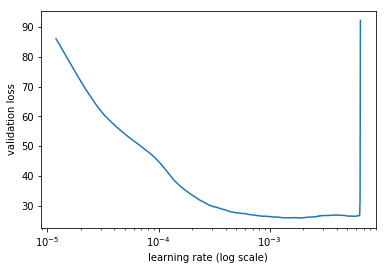

In [47]:
learn.sched.plot(25,0)

Pick a learning rate where the loss still decreases, just before it starts overshooting <br>
Also set the learning rate for the pre-trained layers

In [50]:
lr=2e-4
lrs = np.array([lr/100,lr/10,lr])

Execute one cycle of training and save the model

In [49]:
learn.fit(lrs, 1, cycle_len=2, use_clr=(20,10))
learn.save("fpn-deepfashion-ref")

epoch      trn_loss   val_loss                                  
    0      22.181951  20.863271 
    1      21.239889  19.982155                                 


In [59]:
learn.fit(lrs, 1, cycle_len=3, use_clr=(20,8))
learn.freeze_to(-2)
learn.save("fpn-deepfashion-ref2")

epoch      trn_loss   val_loss                                  
    0      20.405269  19.4052   
    1      19.696923  18.700016                                 
    2      19.14227   18.14751                                  


In [41]:
learn.load("fpn-deepfashion-ref2")
learn.unfreeze()
lr=2e-4
lrs = np.array([lr/100,lr/10,lr])
learn.fit(lrs, 1, cycle_len=3, use_clr=(10,10))
learn.save("fpn-deepfashion-ref3")

epoch      trn_loss   val_loss                                  
    0      17.176399  16.339716 
    1      15.837114  15.388877                                 
    2      15.237435  14.85398                                  



In [41]:
learn.load("fpn-deepfashion-ref3")

In [41]:
learn.load("fpn-deepfashion-ref3")
learn.unfreeze()
lr=2e-4
lrs = np.array([lr/100,lr/10,lr])
learn.fit(lrs, 1, cycle_len=3, use_clr=(10,10))
learn.save("fpn-deepfashion-ref4")

epoch      trn_loss   val_loss                                  
    0      15.278007  15.043625 
    1      14.564098  14.607662                                 
    2      13.981102  14.216063                                 



A function which facilitates the saving of the model so that the learn object can be then loaded back

In [51]:
def save_model(filename, weights):
    learner_state = {}
    learner_state["model"] = models
    learner_state["class"] = learn.__class__
    learner_state["path"] = PATH
    learner_state["classes"] = id2cat
    learner_state["weights"] = weights
    torch.save(learner_state, open(f"../models/{filename}.pkl", 'wb'))
        
save_model("modanet-ref", "fpn-modanet-ref12")

/home/vanio/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type FPN_SSD_Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/vanio/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type OutputConvolution. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Model Evaluation

Non maximum suppression algorithm to discard multiple boxes for the same item

In [42]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    # get the confidence scores ascending order and only take the top-K values
    idx = scores.sort(0)[1][-top_k:]

    # temporary tensors for calculations
    keep = scores.new(scores.size(0)).long()
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()
    
     # calculate the  area of the boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    count = 0
    while idx.numel() > 0:
        # the current largest confidence score and remove it from the list, return if its the last element
        i = idx[-1]  
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]
        
        # get the remaining boxes
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

Display the predictions on items from the validation dataset to explore results

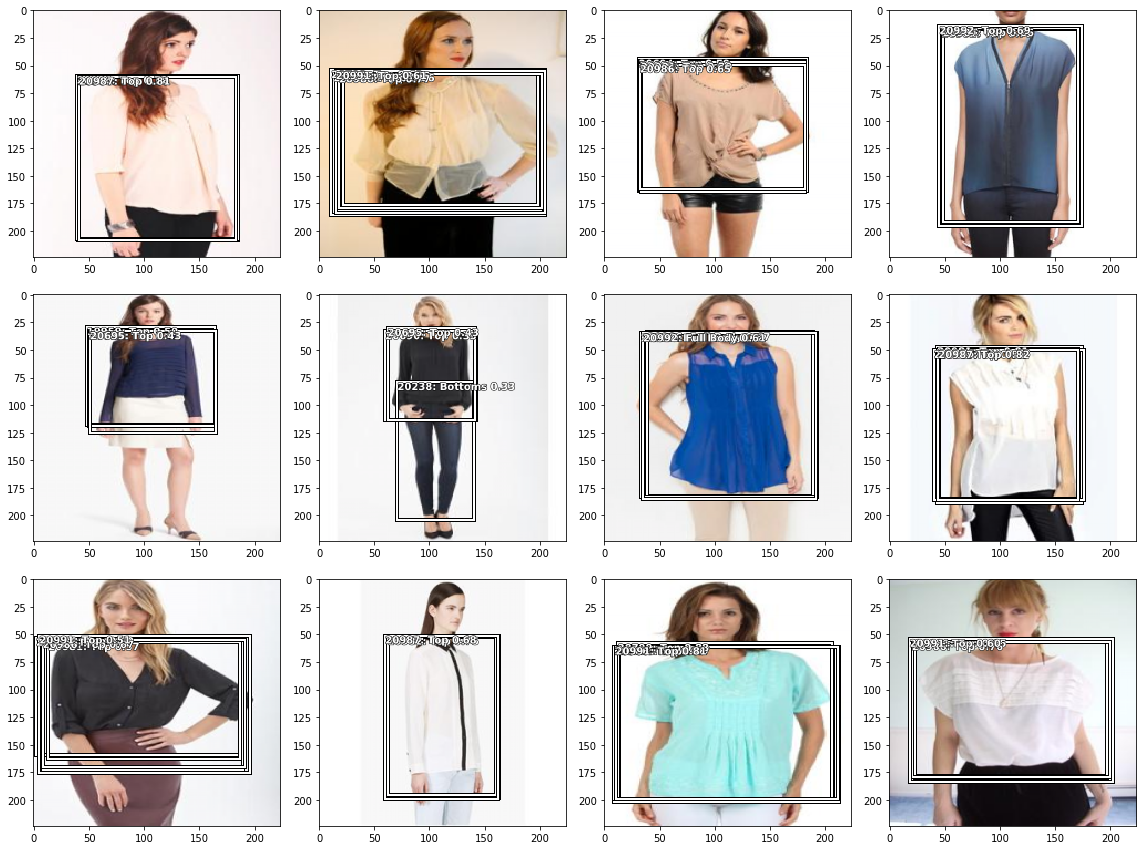

In [113]:
def plot_results(thresh):
    x, y = next(iter(md.val_dl))
    pred_cat, pred_bb = learn.model(V(x))
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(to_np(x))[idx]
        pred_bbs = preds_to_bbs(pred_bb[idx], anchor_hws)
        clas_pr, clas_ids = pred_cat[idx].max(1)
        clas_pr.sigmoid_()
        torch_display_gt(ax, ima, pred_bbs, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()
    
plot_results(0.75)

### Get the predictions on a real-world example

(
  0
  1
 [torch.cuda.LongTensor of size 2 (GPU 0)], 
  0.4628
  0.2963
 [torch.cuda.FloatTensor of size 2 (GPU 0)], 
  0.1733  0.4811  0.5388  0.9357
  0.3959  0.5315  0.9077  0.8358
 [torch.cuda.FloatTensor of size 2x4 (GPU 0)])

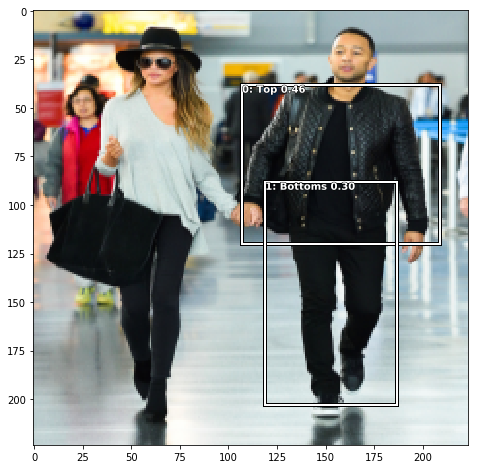

In [43]:
def predict_fn(fn, display=False):
    # open the image and run it through the transforms to pass to the model
    image = open_image(fn)
    image = tfms[1](image, np.array([1,2,3,4]))[0][None]

    # pass the image to the model
    learn.model.cuda()
    learn.model.eval()
    pred_cat,pred_bb = learn.model(V(image))
    
    # get rid of the batch dimension
    pred_cat.squeeze_().sigmoid_()
    pred_bb.squeeze_()
    
    # convert the activations to bounding boxes
    pred_bb = preds_to_bbs(pred_bb, anchor_hws)
    
    # get the probability for each anchor boxes for each category
    conf_scores = pred_cat.t().data
    
    final_scores, final_bbs, final_cats = [],[],[]
    for cat in range(0, len(conf_scores)-1):
        
        # get only the anchor boxes with more than 25% probability
        keep_scores_idxs = conf_scores[cat] > 0.25
        if keep_scores_idxs.sum() == 0: continue
            
        # filter the confidence scores
        scores = conf_scores[cat][keep_scores_idxs]
        
        # filter the bounding boxes
        bbox_keep_idx = keep_scores_idxs.unsqueeze(1).expand_as(pred_bb)
        boxes = pred_bb[bbox_keep_idx].view(-1, 4)
        
        # only keep one bounding box per item
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        
        # append to the final results
        final_scores.append(scores[ids])
        final_bbs.append(boxes.data[ids])
        final_cats.append([cat]*count)

    if not final_cats:
        return [], [], []
    
    final_cats = T(np.concatenate(final_cats))
    final_scores = torch.cat(final_scores)
    final_bbs = torch.cat(final_bbs)
    
    if display:
        ima=md.val_ds.ds.denorm(image)
        fig, ax = plt.subplots(figsize=(8,8))
        torch_display_gt(ax, ima[0], final_bbs, final_cats, final_scores, 0.1)
    
    return final_cats, final_scores, final_bbs

fn ="../john-legend5.jpg"
predict_fn(fn, True)


# mAP Preparation

Create txt files for all the images from the validation set, one with the ground truth objects and one with the predictions. It is then used by an external tool to display statistics

In [45]:
from tqdm import tqdm
from uuid import uuid4


mAP_PATH = Path("../../mAP")
mAP_PATH_GT = mAP_PATH/"ground-truth"
mAP_PATH_PRED = mAP_PATH/"predicted"

# clean up the directory to prepare
!rm {mAP_PATH_GT}/*
!rm {mAP_PATH_PRED}/*

vals = list(val_idxs)
id2cat[-1] = id2cat[-1].replace(" ","-")

for i in tqdm(range(len(val_idxs))):
    fid = uuid4() #trn_fns[vals[i]].split(".")[-2].split("/")[-1]
    annots = md.val_ds[i][1]
    # write ground truth files
    with open(mAP_PATH_GT/f"{fid}.txt", "w") as file:
        for j in range(len(annots[1])):
            bbox_str = " ".join(str(e) for e in annots[0][j*4:j*4+4])
            file.write(f"{id2cat[annots[1][j]]} {bbox_str}\n")
    
    # write the prediction files
    with open(mAP_PATH_PRED/f"{fid}.txt", "w") as file:
        final_cats, final_scores, final_bbs = predict_fn(PATH/JPEGS/trn_fns[vals[i]])
        for cat, score, bbox in zip(final_cats, final_scores, final_bbs):
            bbox_str = " ".join(str(int(e*224)) for e in bbox)
            file.write(f"{id2cat[cat]} {score:.6f} {bbox_str}\n")

rm: cannot remove '../../mAP/ground-truth/*': No such file or directory
rm: cannot remove '../../mAP/predicted/*': No such file or directory


100%|██████████| 40000/40000 [26:00<00:00, 25.73it/s]
